In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
from src import *
from src.optics.utils import *

Adityas-MacBook-Air.local
Running in simulation mode.


/Users/adityasengupta/research/ao/set-tt-control/notebooks/../src/optics/image.py:110: UserWarning: Exposure time in sim optics is not used yet.
  warnings.warn("Exposure time in sim optics is not used yet.")
/Users/adityasengupta/research/ao/set-tt-control/notebooks/../src/optics/image.py:118: UserWarning: Image propagation from the DM has not been implemented.
  warnings.warn("Image propagation from the DM has not been implemented.")


Recomputed interaction matrix and command matrix


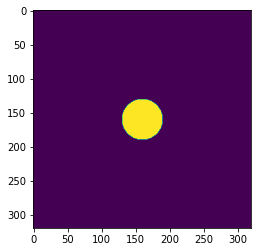

In [42]:
p3i = lambda i: int(round(i)) #python2 to 3: change indicies that are floats to integers

wav0 = 1.65e-6 #assumed wav0 for sine amplitude input in meters
N_act = 32 #number of actuators across the pupil

imagepix = 320
beam_ratio = 5.361256544502618 #pixels/resel
pupilpix = int(round(imagepix/beam_ratio))

grid = np.mgrid[0:imagepix,0:imagepix]
xcen, ycen = imagepix/2, imagepix/2
xy_dh = np.sqrt((grid[1]-imagepix/2.)**2.+(grid[0]-imagepix/2.)**2.)

aperture = np.zeros((imagepix,imagepix))
aperture[np.where(xy_dh<pupilpix/2)] = 1. #unobscured aperture
indpup = np.where(aperture == 1.)
plt.imshow(aperture)

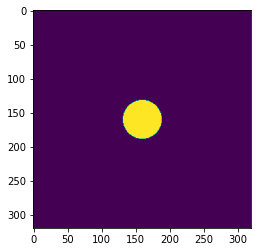

In [43]:
scc_diameter = 1.22*np.sqrt(2.)/32.*pupilpix
left_edge = 1.54*pupilpix-1.22*np.sqrt(2.)/32.*pupilpix/2.
xi_0 = left_edge+scc_diameter/2.
#make scc lyot stop hole in the GPI coronagraph
scc_xpos = imagepix/2. + xi_0
xy = np.sqrt((grid[0]-imagepix/2.)**2. + (grid[1]-scc_xpos)**2.) #radial grid centered on lyot stop hole
ind = np.where(xy < scc_diameter/2.)

lyot_stop = np.zeros(aperture.shape)
lyot_stop[np.where(xy_dh<pupilpix/2.*0.95)] = 1. #slightly undersized pupil
lyot_stop[ind] = 1.
normal_lyot = np.zeros(aperture.shape)
normal_lyot[np.where(xy_dh<pupilpix/2.*0.95)] = 1. #no pinhole
plt.imshow(normal_lyot)

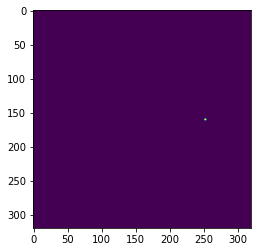

In [44]:
pinhole = np.zeros((imagepix,imagepix))
pinhole[ind] = 1.
plt.imshow(pinhole)

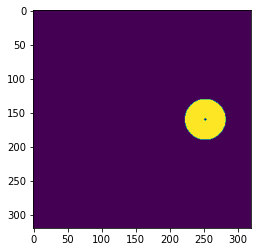

In [45]:
#LLOWFS mask
lowfs_mask = np.zeros((imagepix,imagepix))
xcenmask,ycenmask = imagepix/2+xi_0,imagepix/2.
xypup = np.sqrt((grid[0]-ycenmask)**2.+(grid[1]-xcenmask)**2.)
rcut = pupilpix/2
lowfs_mask[np.where(xypup<rcut)] = 1.
lowfs_mask[ind] = 0.
lowfs_mask[np.where(normal_lyot==1.)] = 0.
plt.imshow(lowfs_mask)

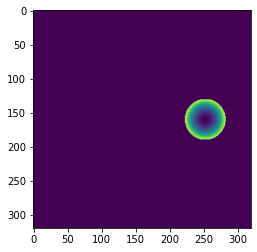

In [46]:
#adding defocus to LLOWFS Lyot plane
xypup[np.where(xypup>rcut)] = 0.
xypup = xypup/np.max(xypup)
defocus = xypup**2.
defocus = defocus - np.mean(defocus[np.where(xypup > 0.)])
defocus = defocus/(np.max(defocus-np.min(defocus)))
plt.imshow(defocus)

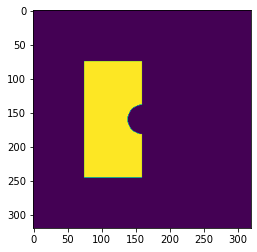

In [47]:
#make TG coronagraph mask:
e = 3 # IWA array in lambda/D
mfpm = np.zeros((imagepix, imagepix))
edge = e * beam_ratio
indfpm = np.where(xy_dh < edge)
mfpm[indfpm] = 1
tlt_unnorm= grid[1] - xcen
tlt_norm = tlt_unnorm / beam_ratio
ld_tlt_amp = -9.6 #tilt angle to steer off axis pupil into the SCC pinhole
tltfpm = tlt_norm * mfpm * ld_tlt_amp
gamp, sigma = 11.5, 2.03 #optimal TG paramegers to centrate the off-axis pupil light
gini = gamp * np.exp(-xy_dh**2./(2.*(sigma*beam_ratio)**2.))
g = gini - np.mean(gini) #subtract the mean so there is a zero piston offset
tg = tlt_norm * mfpm * ld_tlt_amp + g * mfpm

ind_mask_dh = np.where(
	np.logical_and(
		np.logical_and(
			grid[0]>imagepix/2.-N_act/2.*beam_ratio,
			grid[0]<imagepix/2.+N_act/2.*beam_ratio
		),
		np.logical_and(
			np.logical_and(
				grid[1]>imagepix/2.-N_act/2.*beam_ratio,
				grid[1]<imagepix/2.
			),
			xy_dh > (e+1) * beam_ratio
		)
	)
) #half DH ignoring Fourier modes close to the IWA
DH_mask = np.zeros((imagepix,imagepix))
DH_mask[ind_mask_dh] = 1.
plt.imshow(DH_mask)

In [50]:
ygrid, xgrid = grid[0] - ydim/2, grid[1] - xdim/2
tip, tilt = (ygrid + ydim/2)/ydim, (xgrid + xdim/2)/xdim #min value is zero, max is one

In [51]:
def propagate(pupil_phase_dm,pin=True,ph=False,norm=True,m_object=5,t_int=10e-3,Dtel=10,llowfs=False):
    """
    generate scc image
    """
    #photon counting information; from http://www.astronomy.ohio-state.edu/~martini/usefuldata.html using f0 = f_lambda*Delta(lambda), accounting for units
    f0 = 93.3 * 0.29 * 10**8. * 0.03/(0.29/1.63) #photons/m**2/s, mag 0 star, 3 % bandpass centered on H band
    flux_object_ini = f0 * 10.**(-m_object/2.5)
    tr_atm, th, qe = 0.9, 0.2, 0.8 #assume transmission through the atmosphere, instrument throughput, quantum efficiency of CCD
    flux_object = flux_object_ini * tr_atm * th * qe
    Nphot = flux_object * t_int * np.pi * (Dtel/2.)**2. 
    pupil_wavefront_dm_unnorm = aperture * np.exp(1j*(pupil_phase_dm)) #initial 
    norm_phot=np.sum(intensity(np.ones((imagepix,imagepix))[np.where(xy_dh<pupilpix/2.)]))
    pupil_wavefront_dm=complex_amplitude(np.sqrt(intensity(pupil_wavefront_dm_unnorm)/norm_phot*Nphot),phase(pupil_wavefront_dm_unnorm))
    if norm: #normalize by summation; use for control
        norm=np.sum(intensity(np.fft.fftshift(pupil_to_image(pupil_wavefront_dm)))) #different definition of contrast, but this should better normalize diffraction limited to aberation-liited cases, where using only the PSF peak intensity would vary between the two but the sum should not
    else: #normalize by peak lyot value; use for plotting contrast
        norm=np.max(intensity(np.fft.fftshift(pupil_to_image(pupil_wavefront_dm*normal_lyot))))
    fpm_wavefront_ini=np.fft.fftshift(pupil_to_image(pupil_wavefront_dm)) #ft to image plane
    fpm_wavefront=complex_amplitude(np.abs(fpm_wavefront_ini),np.angle(fpm_wavefront_ini)+tg) #add phase mask
    lyot_pupil_wavefront=image_to_pupil(fpm_wavefront) #ift to pupil plane

    if not llowfs:
        if not pin:
            masked_lyot_pupil_wavefront = lyot_pupil_wavefront*normal_lyot #add scc lyot stop in pupil plane
        else:
            masked_lyot_pupil_wavefront = lyot_pupil_wavefront*lyot_stop #add scc lyot stop in pupil plane
        imnorm=intensity(pupil_to_image(masked_lyot_pupil_wavefront))
    else:
        imnorm=intensity(pupil_to_image(complex_amplitude(amplitude(lyot_pupil_wavefront*lowfs_mask),np.angle(lyot_pupil_wavefront)+defocus*focamp*1e-9/wav0*2.*np.pi)))
    if not ph:
        im = imnorm / norm
    else:
        im = np.random.poisson(imnorm) / norm
    return im


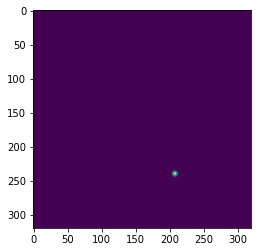

In [52]:
plt.imshow(propagate(50*tip + 30*tilt, ph=True))

In [60]:
nmrms = 100e-9
imagepix = 320
beam_ratio = 5.361256544502618 #pixels/resel
pupilpix = int(round(imagepix/beam_ratio))
phatm = make_noise_pl(nmrms, imagepix, pupilpix, wav0, -2)

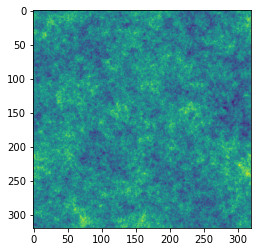

In [61]:
plt.imshow(phatm)

In [64]:
phout_diff = np.load(joinsimdata("ph_diff.npy"))
phout_diff.shape

(1024, 1024)